In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets



In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Data loading and variable declaration

In [3]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


### Define and show widgets
Using ipython widgets create and show widgets for data display option
- Could add observers for each widget to run the data processing step

In [4]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('mcherry',), value='mcherry')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process data based on widget choice
From each widget obtain the selection choice and process the data.

In [20]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, opto_zone_avg, control_zone_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)
placecell_sorted = sort_placecells(placecell_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]



# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates






c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Spatial information 
### Place cells formed / expressed during session2 (opto session)

Get the place cell rate centers and split the spatial information into opto and control zones

In [21]:
# select the session to look at
session_index = 0

# get session from placecell_sorted (complete place cell rates for each session)
placecells = placecell_sorted[session_index]
session_si = placecell_spatial_info[session_index]

# get the place cell centers
centers = get_placecell_centers(placecells)

# split the rates into optozone and control zone and get the ids for the cells in each zone
optozone_rates = placecells[(centers >= opto_bins[0]) & (centers <= opto_bins[1])]
controlzone_rates = placecells[(centers >= control_bins[0]) & (centers <= control_bins[1])]

# get the cell names for just the opto and control zone
optozone_ids = optozone_rates.index.tolist()
controlzone_ids = controlzone_rates.index.tolist()

# re-index the data to get the spatial info for each zone 
optozone_si = session_si.reindex(optozone_ids)
controlzone_si = session_si.reindex(controlzone_ids)



Plot the data for a single experiment.

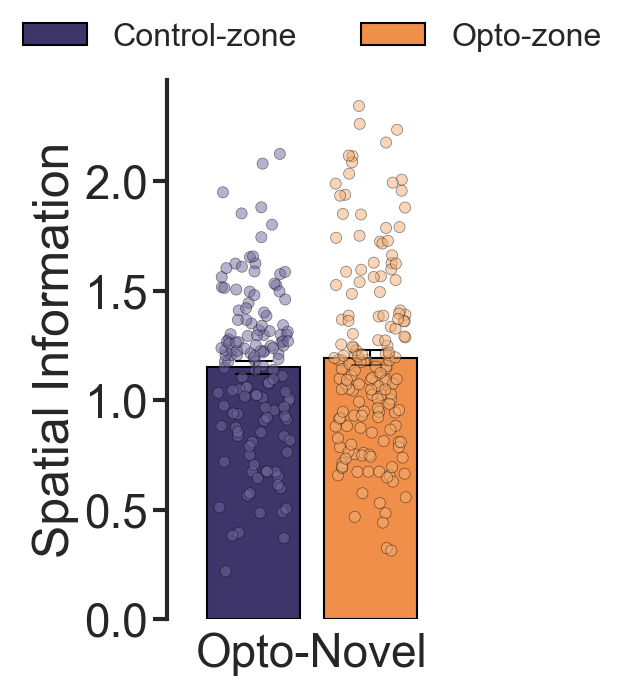

In [22]:
exp_labels = ["Opto-Novel"]

si_df = pd.DataFrame({'Control-zone': pd.Series(controlzone_si[0].values), 'Opto-zone': pd.Series(optozone_si[0].values), 'Experiment': exp_labels[0]})
si_df_melted_df = pd.melt(si_df, id_vars=['Experiment'], value_vars=['Control-zone', 'Opto-zone'], 
                    var_name='Zone', value_name='Spatial Information')


fig = plot_bar_stripplot(data = si_df_melted_df, 
                         x = 'Experiment', 
                         y = 'Spatial Information', 
                         group = 'Zone', 
                         plot_type='barplot', 
                         pallette = joint_pal, 
                         point_pallette = joint_pal_point)

Group multi day experiments together

### Combine multiday experiments
takes a single session from multiple experiment days and plots them together. 

In [23]:
try:
    grouped_spatial_info_opto_s2.append(np.array(optozone_si[0]))
    grouped_spatial_info_ctrl_s2.append(np.array(controlzone_si[0]))
except:
    grouped_spatial_info_opto_s2 = []
    grouped_spatial_info_ctrl_s2 = []
    grouped_spatial_info_opto_s2.append(np.array(optozone_si[0]))
    grouped_spatial_info_ctrl_s2.append(np.array(controlzone_si[0]))

save the data

In [25]:
np.save(save_location + 'spatial_info/spatial_info_opto_s2.npy', np.array(grouped_spatial_info_opto_s2 ,dtype=object), allow_pickle=True)
np.save(save_location + 'spatial_info/spatial_info_ctrl_s2.npy', np.array(grouped_spatial_info_ctrl_s2, dtype=object), allow_pickle=True)

load the data

In [26]:
si_opto = np.load(save_location + 'spatial_info/spatial_info_opto_s2.npy', allow_pickle=True).tolist()
si_control = np.load(save_location + 'spatial_info/spatial_info_ctrl_s2.npy', allow_pickle=True).tolist()

Repackage all the data into a dataframe

In [27]:
y_data_control = si_control
y_data_opto = si_opto

exp_labels = ['Novel', 'Familiar', "mCherry Novel","mCherry Familiar"]

spatial_info_df = pd.DataFrame()
for i in range(len(y_data_control)):
    temp_df = pd.DataFrame({'Control-zone': pd.Series(y_data_control[i]), 'Opto-zone': pd.Series(y_data_opto[i]), 'Experiment': exp_labels[i]})
    spatial_info_df = pd.concat([spatial_info_df,temp_df], ignore_index=True)

spatial_info_melted_df = pd.melt(spatial_info_df, id_vars=['Experiment'], value_vars=['Control-zone', 'Opto-zone'], 
                    var_name='Zone', value_name='Spatial Information')

Calculate the stats between the control and opto zones

In [28]:
exp_pvals = []
for exp in exp_labels:
    exp_df = spatial_info_df[spatial_info_df['Experiment'] == exp]
    exp_pvals.append(stats.ttest_ind(exp_df['Control-zone'].dropna().values,exp_df['Opto-zone'].dropna().values)[1])

exp_pval_stars = [get_significance_stars(p_val) for p_val in exp_pvals]

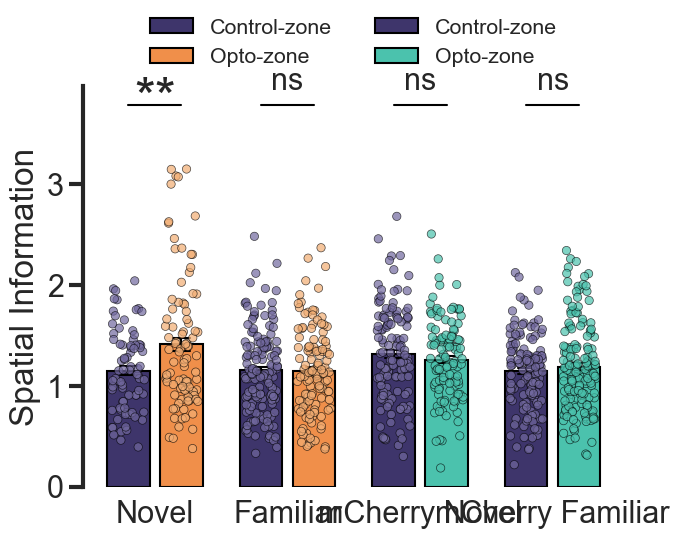

In [29]:
fig = plot_bar_stripplot(spatial_info_melted_df, 
                            x = "Experiment", 
                            y = "Spatial Information", 
                            group = "Zone",
                            stats = exp_pval_stars,  
                            plot_type= 'barplot', 
                            show_ns=True, 
                            fontsize_scale=2,
                            height = 5.2, 
                            width_scale = 1.75, 
                            point_alpha= 0.7, 
                            point_size=7, 
                            line_thickness=3, 
                            pallette = joint_pal,
                            point_pallette = joint_pal_point)

In [31]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
save_path = f"../output_figs/spatial_info/Spatial_info.svg"
fig.savefig(save_path, format='svg')